In [1]:
from pyiron_workflow import Workflow

In [2]:
# Writing a function is as simple as decorating it with @Workflow.wrap.as_function_node()
@Workflow.wrap.as_function_node()
def AddOne(x):
    y = x + 1
    return y

In [3]:
# So now we have a function that adds one to a number.
# But - we can't use it like a normal function:
a = 42
b = AddOne(x=a)  
print(b) # A normal function call would return the result
# This returns an empty node - we need to run it to get the result

AddOne (AddOne):
Inputs ['x']
OutputsWithInjection ['y']
InputSignals ['run', 'accumulate_and_run']
OutputSignals ['ran']


In [4]:
b.run() # or just b() - user's choice!
# And get the result - the output is stored in the node's outputs attribute
# The outputs are stored as a dictionary, with the keys being the names of the outputs
# Here the value is y - since we assigned a=42, and the function adds 1 to it
# The expected output is 43

print(b.outputs.y.value) # Also accessible as b.outputs["y"].value
print(b.outputs["y"].value)

43
43


In [5]:
# A common gotcha - multiple return statements:
# The function being "node-ised" must have only a single return statement - multiple return statements are not allowed
# i.e. The below will return an error
@Workflow.wrap.as_function_node()
def add_one_subtract_1_conditional(x):
    if x > 0:
        y = x + 1
        return y
    else:
        y = x - 1
        return y
# This will return an error
faulty_node = add_one_subtract_1_conditional(x=a)
faulty_node.run()
print(faulty_node.outputs["y"].value)

ValueError: ParseOutput can only parse callables with at most one return value, but ast.walk found 2.

In [6]:
# A simple way to get around this is to use a middleman variable
@Workflow.wrap.as_function_node("y")
def add_one_subtract_1_conditional_middleman(x):
    middleman = x + 1 if x > 0 else x - 1
    return middleman
# This will work
fixed_node = add_one_subtract_1_conditional_middleman(x=a)
fixed_node.run()
print(fixed_node.outputs.y.value)

43


In [7]:
# Adjusting the name of the output is as simple as changing the name of the output in the decorator
@Workflow.wrap.as_function_node("added_one")
def AddOne_moddedoutput(x):
    y = x + 1
    return y

a = 42
b = AddOne_moddedoutput(a)
b.run()
print(b.outputs, b.outputs.added_one.value)

OutputsWithInjection ['added_one'] 43


In [8]:
# Creating our first workflow
wf = Workflow("FirstWorkflow")
# Adding a function node to the workflow
# We can name the workflow node anything we like - in this case add_node
wf.add_node = AddOne(x=42)
# Define a new function node
@Workflow.wrap.as_function_node("y")
def multiply_by_2(x):
    y = x * 2
    return y
# Add the new function node to the workflow - use the output of the previous node as the input
wf.multiply_added = multiply_by_2(x=wf.add_node.outputs.y)
# Running the workflow
wf.run()
# Getting the result
print(wf.add_node.outputs.y.value)
print(wf.multiply_added.outputs.y.value)

43
86


If there's only one output on a node - you can have a syntax shortcut - it will automatically assume that single output is what you want to input into the node.

In [9]:
wf2 = Workflow("SecondWorkflow")
wf2.add_node = AddOne(x=42)
wf2.multiply_added = multiply_by_2(wf2.add_node)
wf2.run()

{'multiply_added__y': 86}

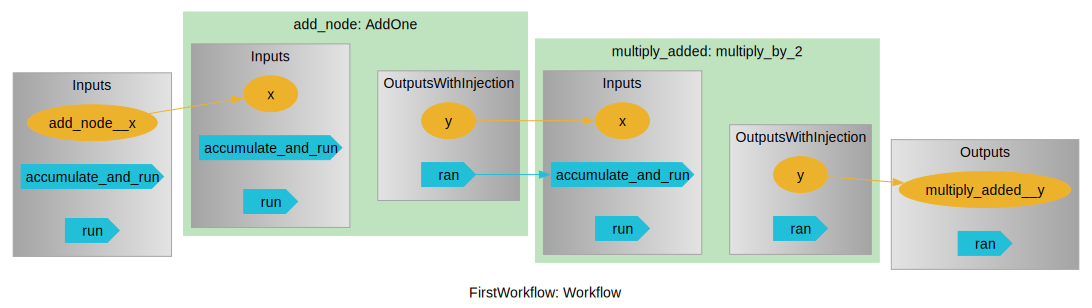

In [10]:
# We can visualise the workflow using the .draw() method
wf.draw()

And now you can see how we can quickly create more complex workflows from here - by linking output of previous nodes to outputs of others